In [1]:
dataset_name = "exchange-2_cpc_results"
path = "data/" + dataset_name + ".csv"
gaussian_window_size = 1024

In [2]:
import adclasses
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


# Preprocess Dataset

In [3]:
data = pd.read_csv(path, header=0)
start_date = data["timestamp"].values[0]
end_date = data["timestamp"].values[-1]
print("Start date: ", start_date)
print("End date: ", end_date)

data["timestamp"] = pd.to_datetime(data["timestamp"], 
                                   format="%Y-%m-%d %H:%M:%S")

print("Missing time stamps: \n", adclasses.find_missing_time_steps(start_date, end_date, 
                                                                   '1H', data))

data =data.drop_duplicates(subset="timestamp")

ad = adclasses.UnivariateAnomalyDetection(dataframe=data, 
                                          timestep="1H", 
                                          dateformat="%Y-%m-%d %H:%M:%S", 
                                          name=dataset_name)
print("Length: ", ad.get_length())
print("Time step size: ", ad.get_timestep())
print("Start Date: ", start_date)
print("End Date: ", end_date)
print("Date Format: ", ad.get_dateformat())
true_outlier_dates = ["2011-07-14 13:00:01"]
true_outlier_indices = ad.convert_true_outlier_date(true_outlier_dates)
print("True outlier indices: ", true_outlier_indices)

Start date:  2011-07-01 00:00:01
End date:  2011-09-07 15:00:01
Missing time stamps: 
 DatetimeIndex(['2011-07-21 05:00:01', '2011-08-08 18:00:01',
               '2011-08-10 16:00:01', '2011-08-15 22:00:01',
               '2011-08-15 23:00:01', '2011-09-01 19:00:01',
               '2011-09-01 20:00:01', '2011-09-01 21:00:01',
               '2011-09-01 22:00:01', '2011-09-01 23:00:01',
               '2011-09-02 00:00:01', '2011-09-02 01:00:01',
               '2011-09-02 02:00:01', '2011-09-02 03:00:01',
               '2011-09-02 04:00:01', '2011-09-02 05:00:01',
               '2011-09-02 06:00:01', '2011-09-02 07:00:01',
               '2011-09-02 08:00:01', '2011-09-02 09:00:01',
               '2011-09-02 10:00:01', '2011-09-02 11:00:01',
               '2011-09-02 12:00:01', '2011-09-02 13:00:01',
               '2011-09-02 14:00:01'],
              dtype='datetime64[ns]', freq=None)
Length:  1648
Time step size:  1H
Start Date:  2011-07-01 00:00:01
End Date:  2011-09-07 15:0

# GLM

In [4]:
# optimize
etas = [.5,1]
lambdas = [.99, .999, .9999]

opt_dict = {}

for eta in etas:
    for lambda_ in lambdas:
       
        mse = ad.glm(gaussian_window_size=gaussian_window_size, 
                     family='gaussian', 
                     eta=eta, 
                     lambda_=lambda_)["MSE"]

        print("eta: ", eta)
        print("lambda: ", lambda_)
        print("MSE: ",mse)

        key_str = "eta " + str(eta) + " lambda " + str(lambda_)

        opt_dict[key_str] = mse

best_params = min(opt_dict, key=opt_dict.get)
print("\nbest params: ", best_params)

  0%|          | 0/1623 [00:00<?, ?it/s]

Initial Mean 0.08890310714170364
Initial StdDev 0.038660775450933875


100%|██████████| 1623/1623 [00:00<00:00, 18861.43it/s]

eta:  0.5
lambda:  0.99
MSE:  0.0004950174563472328
Initial Mean 0.08890310714170364
Initial StdDev 0.038660775450933875



100%|██████████| 1623/1623 [00:00<00:00, 19347.10it/s]

eta:  0.5
lambda:  0.999
MSE:  0.0007846599728318658
Initial Mean 0.08890310714170364
Initial StdDev 0.038660775450933875
eta: 


100%|██████████| 1623/1623 [00:00<00:00, 17080.99it/s]

 0.5
lambda:  0.9999
MSE:  0.0008444198391329778
Initial Mean 0.08890310714170364
Initial StdDev 0.038660775450933875



100%|██████████| 1623/1623 [00:00<00:00, 14331.09it/s]

eta:  1
lambda:  0.99
MSE:  0.00036798909744845397
Initial Mean 0.08890310714170364
Initial StdDev 0.038660775450933875



100%|██████████| 1623/1623 [00:00<00:00, 21994.83it/s]

eta:  1
lambda:  0.999
MSE:  0.0006495278147384001
Initial Mean 0.08890310714170364
Initial StdDev 0.038660775450933875


eta:  1
lambda:  0.9999
MSE:  0.0007336500417695096

best params:  eta 1 lambda 0.99


100%|██████████| 1623/1623 [00:00<00:00, 27187.66it/s]

Initial Mean 0.08890310714170364
Initial StdDev 0.038660775450933875


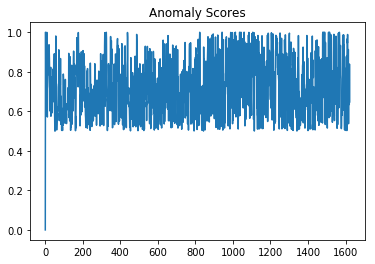

Time:  0.2497093677520752


['anomaly_scores/GLM/exchange-2_cpc_results_no_fill']

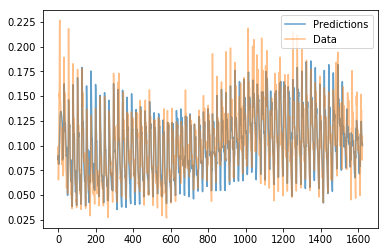

In [5]:
save_path = "anomaly_scores/GLM/" + dataset_name+ "_no_fill"
output_dict = ad.glm(gaussian_window_size=gaussian_window_size, family='gaussian', 
                     eta=int(best_params[4:6]),
                     lambda_=float(best_params[14:]),
                     plot_anomaly_scores=True, plot_forecast=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)


# SARIMA


 Fitting models using approximations to speed things up...

 Regression with ARIMA(2,1,2) errors : -1441.833
 Regression with ARIMA(0,1,0) errors : -1438.744
 Regression with ARIMA(1,1,0) errors : -1439.439
 Regression with ARIMA(0,1,1) errors : -1461.71
 ARIMA(0,1,0)                    : -1441.369
 Regression with ARIMA(1,1,1) errors : -1437.46
 Regression with ARIMA(0,1,2) errors : -1465.497
 Regression with ARIMA(1,1,2) errors : -1435.275
 Regression with ARIMA(0,1,3) errors : -1462.528
 Regression with ARIMA(1,1,3) errors : -1435.579
 ARIMA(0,1,2)                    : -1469.556
 ARIMA(0,1,1)                    : -1468
 ARIMA(1,1,2)                    : -1471.621
 ARIMA(1,1,1)                    : -1464.494
 ARIMA(2,1,2)                    : -1469.79
 ARIMA(1,1,3)                    : -1469.014
 ARIMA(0,1,3)                    : -1467.415
 ARIMA(2,1,1)                    : -1470.859
 ARIMA(2,1,3)                    : -1466.863

 Now re-fitting the best model(s) without approximatio

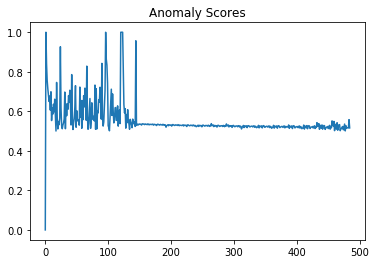

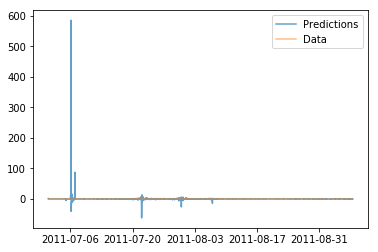

Time:  6.861993074417114


['anomaly_scores/SARIMA_auto/exchange-2_cpc_results_no_fill']

In [6]:
save_path = "anomaly_scores/SARIMA_auto/" + dataset_name+ "_no_fill"
output_dict = ad.sarimax(gaussian_window_size=gaussian_window_size, step_size=100, auto=True,
                         use_exog=True, s=24, plot_anomaly_scores=True,plot_forecast=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# Prophet

In [7]:
# optimization step

step_sizes = [100, 200]
seasonality_prior_scales = [1, 5, 10, 15, 20]
seasonality_modes = ["additive", "multiplicative"]
changepoint_prior_scales = [.01, .05, .1, .15, .2]
opt_dict = {}

for step_size in step_sizes:
    for seasonality_prior_scale in seasonality_prior_scales:
        for seasonality_mode in seasonality_modes:
            for changepoint_prior_scale in changepoint_prior_scales:
                
                mse = ad.facebook_prophet(gaussian_window_size=gaussian_window_size, 
                                          daily_seasonality=True, 
                                          seasonality_prior_scale=seasonality_prior_scale,
                                          seasonality_mode=seasonality_mode,
                                          changepoint_prior_scale=changepoint_prior_scale,
                                          step_size=step_size,
                                          optimize=True)
                print("Step Size: ", step_size)
                print("Seasonality Prior Scale: ", seasonality_prior_scale)
                print("Seasonality Mode: ", seasonality_mode)
                print("Changepoint Prior Scale: ", changepoint_prior_scale)
                print("MSE: ",mse)
                
                key_str = "Step Size " + str(step_size) + " Seasonality Prior Scale " + str(seasonality_prior_scale) +" Seasonality Mode " + str(seasonality_mode) +" Changepoint Prior Scale" + str(changepoint_prior_scale)
                
                opt_dict[key_str] = mse

best_params = min(opt_dict, key=opt_dict.get)
print("\nbest params: ", best_params)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.00033528106108108175


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.00019562845395835603


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.00015771069341956434


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.000151718814924441


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.00014977597264880475


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.0003928218112364853


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.0002320410782435797


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.00018237918155296142


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.0001715247947738035


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.00016760428080489514


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.00033320955478931155


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.00019306965197488115


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.0001579572369023249


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.00015174412167989423


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.00015024837218391993


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.00038581138189517104


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.0002337561265816212


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.0001839977654259469


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.00017126711486533676


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.00016684009159405878


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.0003370746827268764


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.0002147485810484624


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.0001586384595244583


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.00015105670295268299


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.00014987640634254502


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.0003847377723942425


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.0002350380939171735


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.00018194703903077515


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.0001718784998706431


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.00016747399535458135


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.0003346025874743343


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.00021300784751321654


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.0001574100526844474


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.00015182409744127348


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.00014999681316607753


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.0003919510307410407


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.00023713382307043865


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.00018158478954132974


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.00017098176239130377


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.00016766790560085495


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.00033523072267847495


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.00021864895655577878


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.00015780386786291527


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.0001517062108419118


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.00015024007869896775


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.00038380648542819313


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.00022060848855339475


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.0001845848614842699


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.00017191749272047027


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.00016699750110677625


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.00033528106108108175


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.00019562845395835603


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.00015771069341956434


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.000151718814924441


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.00014977597264880475


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.0003928218112364853


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.0002320410782435797


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.00018237918155296142


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.0001715247947738035


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.00016760428080489514


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.00033320955478931155


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.00019306965197488115


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.0001579572369023249


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.00015174412167989423


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.00015024837218391993


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.00038581138189517104


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.0002337561265816212


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.0001839977654259469


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.00017126711486533676


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.00016684009159405878


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.0003370746827268764


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.0002147485810484624


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.0001586384595244583


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.00015105670295268299


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.00014987640634254502


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.0003847377723942425


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.0002350380939171735


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.00018194703903077515


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.0001718784998706431


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.00016747399535458135


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.0003346025874743343


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.00021300784751321654


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.0001574100526844474


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.00015182409744127348


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.00014999681316607753


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.0003919510307410407


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.00023713382307043865


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.00018158478954132974


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.00017098176239130377


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.00016766790560085495


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.00033523072267847495


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.00021864895655577878


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.00015780386786291527


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.0001517062108419118


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.00015024007869896775


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.00038380648542819313


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.00022060848855339475


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.0001845848614842699


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.00017191749272047027
Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.00016699750110677625

best params:  Step Size 100 Seasonality Prior Scale 1 Seasonality Mode additive Changepoint Prior Scale0.2


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


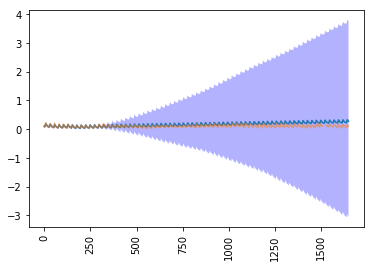

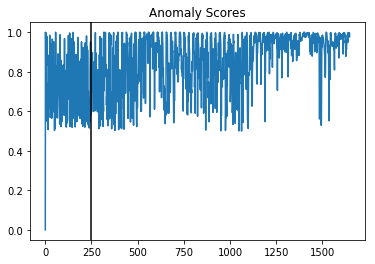

Time:  22.38407039642334


['anomaly_scores/Prophet/exchange-2_cpc_results_no_fill']

In [8]:
save_path = "anomaly_scores/Prophet/" + dataset_name+ "_no_fill"
output_dict = ad.facebook_prophet(gaussian_window_size=gaussian_window_size, 
                                  daily_seasonality=True, 
                                  seasonality_prior_scale=1,
                                  seasonality_mode="additive",
                                  changepoint_prior_scale=.2,
                                  step_size=100,
                                  plot_forecast=True,
                                  plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# STL Resid

In [9]:
# optimization step
swindows = ["periodic", 5,7,9,11]
sdegrees = [0,1,2]
twindows = [5,7,9,11]
tdegrees = [0,1,2]
inners = [1,2,3]
outers = [0,1]
opt_dict = {}

for swindow in swindows:
    for sdegree in sdegrees:
        for twindow in twindows:
            for tdegree in tdegrees:
                for inner in inners:
                    for outer in outers:
                        
                        print("swindow: ", swindow)
                        print("sdegree: ", sdegree)
                        print("twindow: ", twindow)
                        print("tdegree: ", tdegree)
                        print("inner: ", inner)
                        print("outer: ", outer)
                        
                        
                        try:
  
                            stl_resid_sum = ad.stl_resid(gaussian_window_size=gaussian_window_size, step_size=100,n_periods=24, swindow=swindow, 
                                                         sdegree=sdegree, twindow=twindow, tdegree=tdegree, inner=inner, 
                                                         outer=outer, fill_option="linear", optimize=True)


                            print("STL Resid Sum: ",stl_resid_sum)

                            key_str = "swindow " + str(swindow) + " sdegree " + str(sdegree) +" twindow " + str(twindow) +" tdegree " + str(tdegree) +" inner " + str(inner) +" outer " + str(outer)

                            opt_dict[key_str] = stl_resid_sum

                        except:
                            print("Fail")
                            continue

best_params = min(opt_dict, key=opt_dict.get)
print("\nbest params: ", best_params)

swindow:  periodic
sdegree:  0
twindow:  5
tdegree:  0
inner:  1
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.006297415627620497
swindow:  periodic
sdegree:  0
twindow:  5
tdegree:  0
inner:  1
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.00630357014387894
swindow:  periodic
sdegree:  0
twindow:  5
tdegree:  0
inner:  2
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.006297451430056821
swindow:  periodic
sdegree:  0
twindow:  5
tdegree:  0
inner:  2
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.006297415627620497
swindow:  periodic
sdegree:  0
twindow:  5
tdegree:  0
inner:  3
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.006297696563685254
swindow:  periodic
sdegree:  0
twindow:  5
tdegree:  0
inner:  3
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.006297278999343885

R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.0076133710849445166
swindow:  periodic
sdegree:  0
twindow:  9
tdegree:  2
inner:  2
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.00760187417104503
swindow:  periodic
sdegree:  0
twindow:  9
tdegree:  2
inner:  2
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.007603770992330852
swindow:  periodic
sdegree:  0
twindow:  9
tdegree:  2
inner:  3
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.007600778100572758
swindow:  periodic
sdegree:  0
twindow:  9
tdegree:  2
inner:  3
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.007602673056086452
swindow:  periodic
sdegree:  0
twindow:  11
tdegree:  0
inner:  1
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.014328016377427831
swindow:  periodic
sdegree:  0
twindow:  11
tdegree:  0
inner:  1
outer:  1


R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.009681978632810765
swindow:  periodic
sdegree:  1
twindow:  7
tdegree:  1
inner:  2
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.00968361849638656
swindow:  periodic
sdegree:  1
twindow:  7
tdegree:  1
inner:  3
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.009681623728439906
swindow:  periodic
sdegree:  1
twindow:  7
tdegree:  1
inner:  3
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.00968245841350582
swindow:  periodic
sdegree:  1
twindow:  7
tdegree:  2
inner:  1
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.004831485793386979
swindow:  periodic
sdegree:  1
twindow:  7
tdegree:  2
inner:  1
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.004837825448135286
swindow:  periodic
sdegree:  1
twindow:  7
tdegree:  2
inner:  2
outer:  0
247


R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.006297415627620497
swindow:  periodic
sdegree:  2
twindow:  5
tdegree:  0
inner:  3
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.006297696563685254
swindow:  periodic
sdegree:  2
twindow:  5
tdegree:  0
inner:  3
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.006297278999343885
swindow:  periodic
sdegree:  2
twindow:  5
tdegree:  1
inner:  1
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.006277587567116121
swindow:  periodic
sdegree:  2
twindow:  5
tdegree:  1
inner:  1
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.006281771520979735
swindow:  periodic
sdegree:  2
twindow:  5
tdegree:  1
inner:  2
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.006278258552228672
swindow:  periodic
sdegree:  2
twindow:  5
tdegree:  1
inner:  2
outer:  1
24

R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.007602673056086452
swindow:  periodic
sdegree:  2
twindow:  11
tdegree:  0
inner:  1
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.014328016377427831
swindow:  periodic
sdegree:  2
twindow:  11
tdegree:  0
inner:  1
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.014398767834103236
swindow:  periodic
sdegree:  2
twindow:  11
tdegree:  0
inner:  2
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.014315339264111531
swindow:  periodic
sdegree:  2
twindow:  11
tdegree:  0
inner:  2
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.014328016377427831
swindow:  periodic
sdegree:  2
twindow:  11
tdegree:  0
inner:  3
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.01431219076652739
swindow:  periodic
sdegree:  2
twindow:  11
tdegree:  0
inner:  3
outer: 

R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.003402485764221924
swindow:  5
sdegree:  0
twindow:  7
tdegree:  2
inner:  2
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.0033640349853337878
swindow:  5
sdegree:  0
twindow:  7
tdegree:  2
inner:  3
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.003414121987334856
swindow:  5
sdegree:  0
twindow:  7
tdegree:  2
inner:  3
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.003390686592548287
swindow:  5
sdegree:  0
twindow:  9
tdegree:  0
inner:  1
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.007691311841848546
swindow:  5
sdegree:  0
twindow:  9
tdegree:  0
inner:  1
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.00764268363368031
swindow:  5
sdegree:  0
twindow:  9
tdegree:  0
inner:  2
outer:  0
247
R stlplus completed: 247  missing. will 

R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  1.1712814220541973e-05
swindow:  5
sdegree:  1
twindow:  5
tdegree:  2
inner:  1
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  1.6766663759659017e-05
swindow:  5
sdegree:  1
twindow:  5
tdegree:  2
inner:  2
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  4.679231369528501e-06
swindow:  5
sdegree:  1
twindow:  5
tdegree:  2
inner:  2
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  1.1712814220541973e-05
swindow:  5
sdegree:  1
twindow:  5
tdegree:  2
inner:  3
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  1.9715427457934395e-06
swindow:  5
sdegree:  1
twindow:  5
tdegree:  2
inner:  3
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  7.402553308657531e-06
swindow:  5
sdegree:  1
twindow:  7
tdegree:  0
inner:  1
outer:  0
247
R stlplus completed: 247  miss

R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.006363163906925886
swindow:  5
sdegree:  1
twindow:  11
tdegree:  1
inner:  3
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.006402513373590026
swindow:  5
sdegree:  1
twindow:  11
tdegree:  2
inner:  1
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.004936611709207148
swindow:  5
sdegree:  1
twindow:  11
tdegree:  2
inner:  1
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.005005767258230197
swindow:  5
sdegree:  1
twindow:  11
tdegree:  2
inner:  2
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.0049091018586944046
swindow:  5
sdegree:  1
twindow:  11
tdegree:  2
inner:  2
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.004936611709207148
swindow:  5
sdegree:  1
twindow:  11
tdegree:  2
inner:  3
outer:  0
247
R stlplus completed: 247  missing

R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.0009411773618945985
swindow:  5
sdegree:  2
twindow:  9
tdegree:  1
inner:  2
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.000981485096283658
swindow:  5
sdegree:  2
twindow:  9
tdegree:  1
inner:  2
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.0009682736839963755
swindow:  5
sdegree:  2
twindow:  9
tdegree:  1
inner:  3
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.0009702799496257635
swindow:  5
sdegree:  2
twindow:  9
tdegree:  1
inner:  3
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.0009826970994843407
swindow:  5
sdegree:  2
twindow:  9
tdegree:  2
inner:  1
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.0006208037883004453
swindow:  5
sdegree:  2
twindow:  9
tdegree:  2
inner:  1
outer:  1
247
R stlplus completed: 247  missing. 

R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.00788409409775549
swindow:  7
sdegree:  0
twindow:  7
tdegree:  0
inner:  3
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.007860661250693058
swindow:  7
sdegree:  0
twindow:  7
tdegree:  1
inner:  1
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.007798558777948311
swindow:  7
sdegree:  0
twindow:  7
tdegree:  1
inner:  1
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.007735502054492003
swindow:  7
sdegree:  0
twindow:  7
tdegree:  1
inner:  2
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.007834527320775244
swindow:  7
sdegree:  0
twindow:  7
tdegree:  1
inner:  2
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.007798558777948311
swindow:  7
sdegree:  0
twindow:  7
tdegree:  1
inner:  3
outer:  0
247
R stlplus completed: 247  missing. will f

R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.004586864624598688
swindow:  7
sdegree:  1
twindow:  5
tdegree:  0
inner:  2
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.004569504498127205
swindow:  7
sdegree:  1
twindow:  5
tdegree:  0
inner:  3
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.004590304307921031
swindow:  7
sdegree:  1
twindow:  5
tdegree:  0
inner:  3
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.004582778877870146
swindow:  7
sdegree:  1
twindow:  5
tdegree:  1
inner:  1
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.0045445485244074565
swindow:  7
sdegree:  1
twindow:  5
tdegree:  1
inner:  1
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.0045117658218423815
swindow:  7
sdegree:  1
twindow:  5
tdegree:  1
inner:  2
outer:  0
247
R stlplus completed: 247  missing. wil

R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.009457026782310916
swindow:  7
sdegree:  1
twindow:  11
tdegree:  0
inner:  1
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.009565362162418708
swindow:  7
sdegree:  1
twindow:  11
tdegree:  0
inner:  2
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.009435469307486611
swindow:  7
sdegree:  1
twindow:  11
tdegree:  0
inner:  2
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.009457026782310916
swindow:  7
sdegree:  1
twindow:  11
tdegree:  0
inner:  3
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.00942854687236965
swindow:  7
sdegree:  1
twindow:  11
tdegree:  0
inner:  3
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.009442267753153924
swindow:  7
sdegree:  1
twindow:  11
tdegree:  1
inner:  1
outer:  0
247
R stlplus completed: 247  missing. 

R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.0023768921487523262
swindow:  7
sdegree:  2
twindow:  7
tdegree:  2
inner:  3
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.0024151534599343503
swindow:  7
sdegree:  2
twindow:  9
tdegree:  0
inner:  1
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.0053842167537670816
swindow:  7
sdegree:  2
twindow:  9
tdegree:  0
inner:  1
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.005496764686963054
swindow:  7
sdegree:  2
twindow:  9
tdegree:  0
inner:  2
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.005351406677058723
swindow:  7
sdegree:  2
twindow:  9
tdegree:  0
inner:  2
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.0053842167537670816
swindow:  7
sdegree:  2
twindow:  9
tdegree:  0
inner:  3
outer:  0
247
R stlplus completed: 247  missing. w

R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.00010682680613841131
swindow:  9
sdegree:  0
twindow:  5
tdegree:  2
inner:  2
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.00012035363345785004
swindow:  9
sdegree:  0
twindow:  5
tdegree:  2
inner:  3
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  9.794153893276826e-05
swindow:  9
sdegree:  0
twindow:  5
tdegree:  2
inner:  3
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.00011284080893117314
swindow:  9
sdegree:  0
twindow:  7
tdegree:  0
inner:  1
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.008301439509674017
swindow:  9
sdegree:  0
twindow:  7
tdegree:  0
inner:  1
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.00823545866263317
swindow:  9
sdegree:  0
twindow:  7
tdegree:  0
inner:  2
outer:  0
247
R stlplus completed: 247  missing.

R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.008335326278763825
swindow:  9
sdegree:  0
twindow:  11
tdegree:  2
inner:  1
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.008338828766520149
swindow:  9
sdegree:  0
twindow:  11
tdegree:  2
inner:  2
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.008355967174175425
swindow:  9
sdegree:  0
twindow:  11
tdegree:  2
inner:  2
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.008335326278763825
swindow:  9
sdegree:  0
twindow:  11
tdegree:  2
inner:  3
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.008360311804753806
swindow:  9
sdegree:  0
twindow:  11
tdegree:  2
inner:  3
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.00834900156052691
swindow:  9
sdegree:  1
twindow:  5
tdegree:  0
inner:  1
outer:  0
247
R stlplus completed: 247  missing. w

R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.0092708789418423
swindow:  9
sdegree:  1
twindow:  9
tdegree:  1
inner:  3
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.009278472779698217
swindow:  9
sdegree:  1
twindow:  9
tdegree:  2
inner:  1
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.00613929167419211
swindow:  9
sdegree:  1
twindow:  9
tdegree:  2
inner:  1
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.006175441618637422
swindow:  9
sdegree:  1
twindow:  9
tdegree:  2
inner:  2
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.006132353101983572
swindow:  9
sdegree:  1
twindow:  9
tdegree:  2
inner:  2
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.00613929167419211
swindow:  9
sdegree:  1
twindow:  9
tdegree:  2
inner:  3
outer:  0
247
R stlplus completed: 247  missing. will fill

R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.00570028890917957
swindow:  9
sdegree:  2
twindow:  7
tdegree:  1
inner:  2
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.005749750209208141
swindow:  9
sdegree:  2
twindow:  7
tdegree:  1
inner:  3
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.005682087308449401
swindow:  9
sdegree:  2
twindow:  7
tdegree:  1
inner:  3
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.0057182748280775455
swindow:  9
sdegree:  2
twindow:  7
tdegree:  2
inner:  1
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.002942847110412925
swindow:  9
sdegree:  2
twindow:  7
tdegree:  2
inner:  1
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.0030206661394072127
swindow:  9
sdegree:  2
twindow:  7
tdegree:  2
inner:  2
outer:  0
247
R stlplus completed: 247  missing. will

R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.005686330428968737
swindow:  11
sdegree:  0
twindow:  5
tdegree:  1
inner:  1
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.005648369201000256
swindow:  11
sdegree:  0
twindow:  5
tdegree:  1
inner:  2
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.005715135136367485
swindow:  11
sdegree:  0
twindow:  5
tdegree:  1
inner:  2
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.005686330428968737
swindow:  11
sdegree:  0
twindow:  5
tdegree:  1
inner:  3
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.005718601862467681
swindow:  11
sdegree:  0
twindow:  5
tdegree:  1
inner:  3
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.005707820502255308
swindow:  11
sdegree:  0
twindow:  5
tdegree:  2
inner:  1
outer:  0
247
R stlplus completed: 247  missing.

R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.012406376070271662
swindow:  11
sdegree:  0
twindow:  11
tdegree:  0
inner:  3
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.01246975745076338
swindow:  11
sdegree:  0
twindow:  11
tdegree:  0
inner:  3
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.012450505470717303
swindow:  11
sdegree:  0
twindow:  11
tdegree:  1
inner:  1
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.011745693135082821
swindow:  11
sdegree:  0
twindow:  11
tdegree:  1
inner:  1
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.01158919330175587
swindow:  11
sdegree:  0
twindow:  11
tdegree:  1
inner:  2
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.011787810121145175
swindow:  11
sdegree:  0
twindow:  11
tdegree:  1
inner:  2
outer:  1
247
R stlplus completed: 247  miss

R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.010115734254952038
swindow:  11
sdegree:  1
twindow:  9
tdegree:  0
inner:  1
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.01018226209366744
swindow:  11
sdegree:  1
twindow:  9
tdegree:  0
inner:  2
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.01010157604298507
swindow:  11
sdegree:  1
twindow:  9
tdegree:  0
inner:  2
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.010115734254952038
swindow:  11
sdegree:  1
twindow:  9
tdegree:  0
inner:  3
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.010094344661240711
swindow:  11
sdegree:  1
twindow:  9
tdegree:  0
inner:  3
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.01010713873184528
swindow:  11
sdegree:  1
twindow:  9
tdegree:  1
inner:  1
outer:  0
247
R stlplus completed: 247  missing. wi

R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  2.0473620292974396e-05
swindow:  11
sdegree:  2
twindow:  5
tdegree:  2
inner:  3
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  3.024879239235468e-06
swindow:  11
sdegree:  2
twindow:  5
tdegree:  2
inner:  3
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  1.2753112712393189e-05
swindow:  11
sdegree:  2
twindow:  7
tdegree:  0
inner:  1
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.006540021371440014
swindow:  11
sdegree:  2
twindow:  7
tdegree:  0
inner:  1
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.006609626282470056
swindow:  11
sdegree:  2
twindow:  7
tdegree:  0
inner:  2
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.006523878729472857
swindow:  11
sdegree:  2
twindow:  7
tdegree:  0
inner:  2
outer:  1
247
R stlplus completed: 247  mis

R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.006443131309918659
swindow:  11
sdegree:  2
twindow:  11
tdegree:  2
inner:  1
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.0065551332482927
swindow:  11
sdegree:  2
twindow:  11
tdegree:  2
inner:  2
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.006431667673258395
swindow:  11
sdegree:  2
twindow:  11
tdegree:  2
inner:  2
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.006443131309918659
swindow:  11
sdegree:  2
twindow:  11
tdegree:  2
inner:  3
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.006431656659198176
swindow:  11
sdegree:  2
twindow:  11
tdegree:  2
inner:  3
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.006433284261673872

best params:  swindow 5 sdegree 2 twindow 5 tdegree 2 inner 3 outer 0


In [10]:
save_path = "anomaly_scores/stl/" + dataset_name+ "_no_fill"
output_dict = ad.stl_resid(gaussian_window_size=gaussian_window_size, step_size=100,n_periods=24, swindow=5, 
             sdegree=2, twindow=5, tdegree=2, inner=3, 
             outer=0, fill_option="linear", optimize=False)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

1648
R stlplus completed: 1648  missing. will fill. True
Time:  2.077303886413574


['anomaly_scores/stl/exchange-2_cpc_results_no_fill']